In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epidemy/dengue_labels_train.csv
/kaggle/input/epidemy/dengue_features_train.csv
/kaggle/input/epidemy/dengue_features_test.csv
/kaggle/input/epidemy/submission_format.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from platform import python_version
python_version()

'3.7.12'

In [3]:
# Some stuff from the Feature Engineering Course:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

Some relevant info from google: female mosquito lifetime is 42-56 days, male is 10
That is approximately 7 weeks for female mosquitos. So probably don't need to consider lags beyond that for weather features.

In [4]:
dengue_features_train = pd.read_csv('../input/epidemy/dengue_features_train.csv',parse_dates=True,infer_datetime_format=True)
dengue_features_test = pd.read_csv('../input/epidemy/dengue_features_test.csv',parse_dates=True,infer_datetime_format=True)
dengue_labels_train   = pd.read_csv('../input/epidemy/dengue_labels_train.csv',parse_dates=True,infer_datetime_format=True)


In [5]:
for col in dengue_features_train.columns:
    print(col)

city
year
weekofyear
week_start_date
ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
precipitation_amt_mm
reanalysis_air_temp_k
reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_sat_precip_amt_mm
reanalysis_specific_humidity_g_per_kg
reanalysis_tdtr_k
station_avg_temp_c
station_diur_temp_rng_c
station_max_temp_c
station_min_temp_c
station_precip_mm


In [6]:
from datetime import date, timedelta
import datetime
import math

debug_date_map=True

# store information on 
date_map_debug_logs=[]

set_of_bad_years=set()

# map from dataframe with year, weekofyear features
# to a time index
# lets go with weeks since day 1 of week 1 of 1990
def date_start_map(x):
    year_one=1990
    week_one=1
    day_of_week=1
    # Trying thursday
    date_one = datetime.datetime.strptime(f"{year_one}-U{week_one}-{day_of_week}","%Y-U%U-%w").date()

    year_current = x['year']
    week_current = x['weekofyear']


    # trouble years are those where this data set incorrectly assigns a week at the 
    # beginning to the end. I've identified these as those starting with Friday, Saturday,
    # or Sunday
    raw_year_current = year_current
    raw_week_current = week_current
    trouble_year=False
    shift = 0
    year_start_date = datetime.datetime.strptime(f"{year_current}-M{1}-{1}","%Y-M%m-%d").date()

    date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()
    if (year_start_date.weekday() >= 4):
        trouble_year=True
        set_of_bad_years.add(year_current)
        # need better check
        if (week_current >= 52):
            year_current-=1
            # trying to assign to Dec 31
            date_two = datetime.datetime.strptime(f"{year_current}-M{12}-{31}","%Y-M%m-%d").date()
        else:
            shift = 1
            date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()    
    time_d = date_two - date_one
    weeks = math.ceil(time_d.days / 7.0)
    weeks += shift
    if debug_date_map:
        debug_log=f"{raw_year_current}-{raw_week_current} mapped to week {weeks} using days {time_d.days}"
        date_map_debug_logs.append(debug_log)
    
    return weeks
startmap=date_start_map

dengue_features_train['weeks_since_start']=dengue_features_train.apply(startmap,axis=1)
dengue_features_test['weeks_since_start']=dengue_features_test.apply(startmap,axis=1)
dengue_labels_train['weeks_since_start']=dengue_labels_train.apply(startmap,axis=1)

dengue_features_sj_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='sj'])
dengue_features_sj_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='sj'])
dengue_labels_sj_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='sj'])

dengue_features_iq_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='iq'])
dengue_features_iq_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='iq'])
dengue_labels_iq_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='iq'])

list_of_frames=[
    dengue_features_sj_train,
    dengue_features_sj_test,
    dengue_labels_sj_train,
    dengue_features_iq_train,
    dengue_features_iq_test,
    dengue_labels_iq_train
]
for frame in list_of_frames:
    frame.sort_values('weeks_since_start',inplace=True)
    frame.set_index('weeks_since_start',inplace=True)

    
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


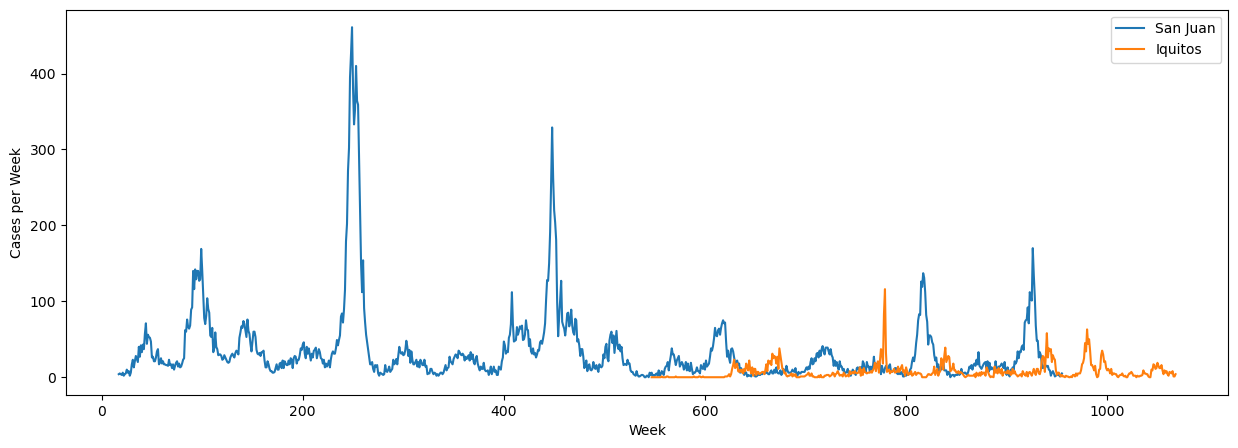

In [7]:
ax=dengue_labels_sj_train.loc[:,['total_cases']].plot(figsize=(15,5))
dengue_labels_iq_train.loc[:,['total_cases']].plot(ax=ax)
ax.legend(['San Juan','Iquitos'])
ax.set(xlabel="Week",ylabel="Cases per Week")
plt.savefig('cases_data.png')

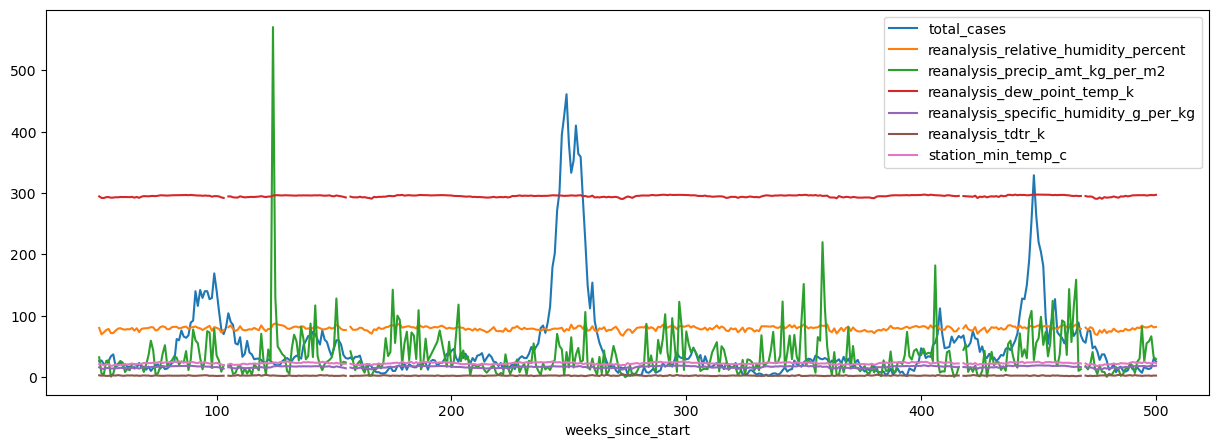

In [8]:
start_week=50
end_week=500

features_to_plot=['reanalysis_relative_humidity_percent',
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_specific_humidity_g_per_kg',
                  'reanalysis_tdtr_k',
                 'station_min_temp_c']
ax=dengue_labels_sj_train.loc[start_week:end_week,['total_cases']].plot(figsize=(15,5))
dengue_features_sj_train.loc[start_week:end_week,features_to_plot].plot(ax=ax)
plt.savefig('test_feature_cmp_sj.png')

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


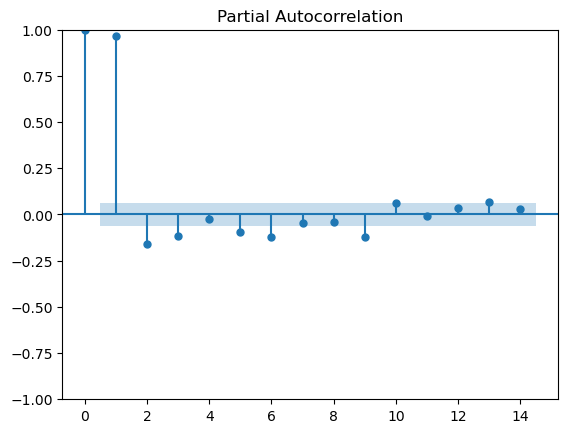

In [9]:
from learntools.time_series.utils import plot_lags, make_lags, make_leads
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dengue_labels_sj_train['total_cases'], lags=14);
plt.savefig('cases_sj_pacf.png')

# Variables


In [10]:
# Averaging Vegetation Index data
ndvi_features=['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']

dengue_features_sj_train_ndvi_mean=dengue_features_sj_train[ndvi_features].mean(axis=1)
dengue_features_sj_train['ndvi_mean']=dengue_features_sj_train_ndvi_mean

In [11]:
precip_variable='reanalysis_sat_precip_amt_mm'
ndvi_variable='ndvi_mean'
rel_hum_variable='reanalysis_relative_humidity_percent'
dew_point_variable='reanalysis_dew_point_temp_k'
mean_temp_variable='reanalysis_avg_temp_k'

variables_of_interest=[precip_variable,ndvi_variable,
                       rel_hum_variable,dew_point_variable,
                       mean_temp_variable]
# for labelling
varnames_of_interest=['precip','ndvi','rel_hum','dew_pt','mean_temp']
vartitles_of_interest=['Precipitation','Vegetation Index','Relative Humidity','Dew Point','Mean Temp']

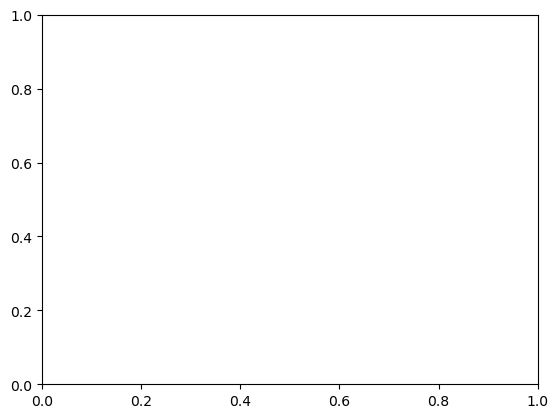

In [12]:
smoothed_features=[]
for i in range(len(variables_of_interest)):
    variable=variables_of_interest[i]
    varname=varnames_of_interest[i]
    vartitle=vartitles_of_interest[i]
    variable_rolling = dengue_features_sj_train[variable].rolling(window=5,center=False).mean()
    smoothed_features.append(variable_rolling)
    ax = dengue_features_sj_train[variable].plot(label=vartitle)
    variable_rolling.plot(ax=ax,label="%s (smoothed)" % (vartitle))
    ax.legend()
    #ax.set_ylabel(vartitle_of_interest[i])
    plt.savefig("variable_%s_smoothed.png" % (varname))
    ax.clear()

# Section: Target and Feature Lags

In [13]:
y_sj=dengue_labels_sj_train['total_cases']

In [14]:
target_lag_number = 12

y_sj_lags=make_lags(dengue_labels_sj_train['total_cases'],lags=target_lag_number)

In [15]:
# can use code from Time Series course

n_lags=24

lags_list=[]
lags_list_no_target=[]
for i in range(len(variables_of_interest)):
    var_lags=make_lags(dengue_features_sj_train[variables_of_interest[i]],
                       lags=n_lags,name=varnames_of_interest[i])
    lags_list.append(var_lags)
    lags_list_no_target.append(var_lags)
    
# add target lags
lags_list.append(y_sj_lags)
    
smoothed_lags_list=[]
smoothed_lags_list_no_target=[]
for i in range(len(variables_of_interest)):
    var_lags=make_lags(smoothed_features[i],
                       lags=n_lags,name="%s_smooth" % (varnames_of_interest[i]))
    smoothed_lags_list.append(var_lags)
    smoothed_lags_list_no_target.append(var_lags)

smoothed_lags_list.append(y_sj_lags)


In [16]:
#lags_list

In [17]:
dengue_features_sj_train_lags=pd.concat(lags_list, axis=1)
dengue_features_no_target_sj_train_lags=pd.concat(lags_list_no_target, axis=1)

dengue_smoothed_features_sj_train_lags=pd.concat(smoothed_lags_list, axis=1)
dengue_smoothed_features_no_target_sj_train_lags=pd.concat(smoothed_lags_list_no_target, axis=1)

In [18]:


X_lags_no_target_for_mi=dengue_features_no_target_sj_train_lags.dropna()
X_lags_for_mi=dengue_features_sj_train_lags.dropna()
#print(X_lags_no_target_for_mi)

(y_lags_no_target_for_mi,X_lags_no_target_for_mi) = y_sj.align(X_lags_no_target_for_mi, join='inner', axis=0)
(y_lags_for_mi,X_lags_for_mi) = y_sj.align(X_lags_for_mi, join='inner', axis=0)
print(X_lags_no_target_for_mi.shape)
print(y_lags_no_target_for_mi.shape)

mi_scores = make_mi_scores(X_lags_no_target_for_mi, y_lags_no_target_for_mi, 'auto')
mi_with_target_scores = make_mi_scores(X_lags_for_mi, y_lags_for_mi, 'auto')

(675, 120)
(675,)


In [19]:
print(mi_scores.head(24))

dew_pt_lag_8        0.260135
dew_pt_lag_6        0.242398
dew_pt_lag_10       0.236708
dew_pt_lag_7        0.228833
dew_pt_lag_11       0.225210
mean_temp_lag_10    0.223345
dew_pt_lag_9        0.222951
mean_temp_lag_8     0.214499
mean_temp_lag_7     0.205921
dew_pt_lag_13       0.204920
mean_temp_lag_9     0.196971
dew_pt_lag_4        0.194895
mean_temp_lag_5     0.193214
mean_temp_lag_6     0.188005
dew_pt_lag_12       0.185969
mean_temp_lag_12    0.175426
dew_pt_lag_5        0.167242
mean_temp_lag_13    0.162896
dew_pt_lag_3        0.160896
mean_temp_lag_11    0.152670
rel_hum_lag_8       0.141431
dew_pt_lag_2        0.138393
dew_pt_lag_1        0.136035
mean_temp_lag_4     0.130744
Name: MI Scores, dtype: float64


In [20]:
print(mi_with_target_scores.head(20))

y_lag_1             1.046259
y_lag_2             0.850337
y_lag_3             0.713796
y_lag_4             0.609809
y_lag_5             0.504746
y_lag_6             0.398425
y_lag_7             0.329446
dew_pt_lag_8        0.259099
y_lag_8             0.254807
dew_pt_lag_10       0.245375
dew_pt_lag_6        0.240955
dew_pt_lag_9        0.225296
dew_pt_lag_11       0.224696
mean_temp_lag_10    0.223346
dew_pt_lag_7        0.222052
mean_temp_lag_8     0.210788
dew_pt_lag_4        0.200816
mean_temp_lag_9     0.196776
dew_pt_lag_13       0.196063
mean_temp_lag_7     0.195400
Name: MI Scores, dtype: float64


Studying Derivatives

In [21]:
y_sj_deriv=dengue_labels_sj_train['total_cases']-y_sj_lags['y_lag_1']

In [22]:
y_sj_deriv_smooth_gaus_mean=y_sj_deriv.rolling(window=7,center=True,win_type='gaussian').mean(std=3)
y_sj_deriv_smooth_const_mean=y_sj_deriv.rolling(window=7,center=True).mean(std=3)


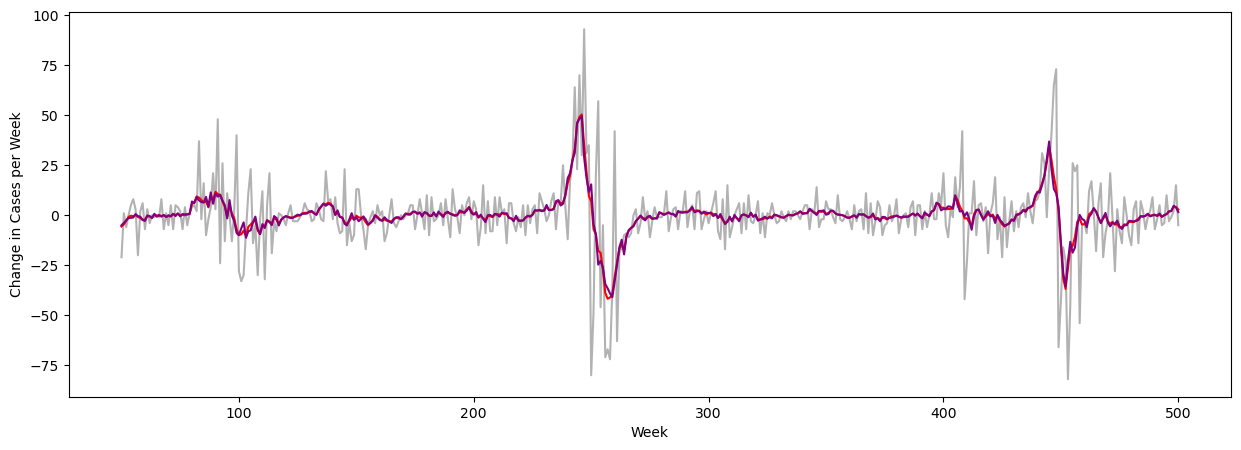

In [23]:
START=50
END=500
ax=y_sj_deriv.loc[START:END].plot(figsize=(15,5),color='black',alpha=0.3)
y_sj_deriv_smooth_gaus_mean.loc[START:END].plot(ax=ax,label='Gaussian Smooth',color='red')
y_sj_deriv_smooth_const_mean.loc[START:END].plot(ax=ax,label='Flat Window',color='purple')
ax.set(xlabel="Week",ylabel="Change in Cases per Week")
plt.savefig("deriv_smoothing.png")

In [24]:
from sklearn.model_selection import train_test_split

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=6, desat=None)
    #palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        #preds.index = pd.period_range(start=date, periods=len(preds))
        preds.index = range(date,date+len(preds))
        preds.plot(ax=ax,label=f"Forecast from {date}")
    return ax


In [25]:
target_forecast_steps=20
y_sj_multistep = make_multistep_target(y_sj,steps=target_forecast_steps).dropna()

# Defining Inputs and Models

In [26]:
# each model may require different X,y
# especially based on rows we remove

list_X=[]
list_y=[]

model_list=[]
model_labels=[]
model_titles=[]

X_train_list=[]
X_valid_list=[]
y_train_list=[]
y_valid_list=[]

# Defining Models

In [27]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error

In [28]:
list_X=[]
list_y=[]

model_list=[]
model_labels=[]
model_titles=[]

X_train_list=[]
X_valid_list=[]
y_train_list=[]
y_valid_list=[]



n_estimators=30
n_jobs=4

model_labels.append("RegChain1_Target_Only")
model_titles.append("Regressor Chain 1 Target Only")
model_1 = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model_1)

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)


model_labels.append("RegChain1_Dew")
model_titles.append("Regressor Chain 1 Dew")
model_1 = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model_1)

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)


pass

model_labels.append("RegChain1_Dew_Temp")
model_titles.append("Regressor Chain 1 Dew Temp")
model = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model)

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'mean_temp_lag_6','mean_temp_lag_7','mean_temp_lag_8',
                    'mean_temp_lag_9','mean_temp_lag_10','mean_temp_lag_11'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)

model_labels.append("RegChain1_Dew_Temp_Hum")
model_titles.append("Regressor Chain 1 Dew Temp Hum")
model = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model)


features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'mean_temp_lag_6','mean_temp_lag_7','mean_temp_lag_8',
                    'mean_temp_lag_9','mean_temp_lag_10','mean_temp_lag_11',
                    'rel_hum_lag_6','rel_hum_lag_7','rel_hum_lag_8',
                    'rel_hum_lag_9','rel_hum_lag_10','rel_hum_lag_11'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)


model_labels.append("RegChain1_Dew_Temp_Hum_Precip")
model_titles.append("Regressor Chain 1 Dew Temp Hum Precip")
model = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model)

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'mean_temp_lag_6','mean_temp_lag_7','mean_temp_lag_8',
                    'mean_temp_lag_9','mean_temp_lag_10','mean_temp_lag_11',
                    'rel_hum_lag_6','rel_hum_lag_7','rel_hum_lag_8',
                    'rel_hum_lag_9','rel_hum_lag_10','rel_hum_lag_11',
                    'precip_lag_2','precip_lag_3','precip_lag_4','precip_lag_5',
                    'precip_lag_6','precip_lag_7','precip_lag_8','precip_lag_9'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)

In [29]:
# Neural Network models

# need to make multiple outputs.

from tensorflow import keras
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras import layers


In [30]:
# NN Model 1

# temporarily resetting lists for testing
if (False):
    list_X=[]
    list_y=[]

    model_list=[]
    model_labels=[]
    model_titles=[]

    X_train_list=[]
    X_valid_list=[]
    y_train_list=[]
    y_valid_list=[]

    
#nn_loss_choice='mean_squared_logarithmic_error'
nn_loss_choice='mse'
# would some loss options emphasize the peaked outbreaks better?
#Should the different time step outputs have different losses?
    

model_labels.append("NN_1_Dew")
model_titles.append("Neural Network 1 Dew")
features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_1','dew_pt_lag_2','dew_pt_lag_3',
                    'dew_pt_lag_4','dew_pt_lag_5','dew_pt_lag_6',
                    'dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

print(local_X.shape[1])
inputs = Input(shape=(local_X.shape[1],),name='input')
print(inputs)

x = BatchNormalization()(inputs)
x = Dense(20, activation='relu',name='layer2')(x)
x = BatchNormalization()(x)
x = Dense(20, activation='relu',name='layer3')(x)
x = Dense(20, activation='sigmoid',name='layer4')(x)
x = Dense(20, activation=None,name='layer5')(x)

# making a separate output layer for each output
#output_layers=[]
#for col in local_y.columns:
#    output_layer=Dense(1,name=col)(x)
#    output_layers.append(output_layer)

model = Model(inputs=inputs,outputs=x)
#model = Model(inputs=inputs,outputs=output_layers)
loss_dict={}
for col in local_y.columns:
    loss_dict[col]=nn_loss_choice
    
#model.compile(loss=loss_dict,optimizer='adam')
model.compile(loss=nn_loss_choice,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn1.png", show_shapes=True)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)





model_labels.append("NN_2_Dew")
model_titles.append("Neural Network 2 Dew")
features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

print(local_X.shape[1])
inputs = Input(shape=(local_X.shape[1],),name='input')
print(inputs)

x = BatchNormalization()(inputs)
x = Dense(20, activation='relu',name='layer2')(x)
x = BatchNormalization()(x)
x = Dense(20, activation='relu',name='layer3')(x)
x = Dense(20, activation='sigmoid',name='layer4')(x)
x = Dense(20, activation=None,name='layer5')(x)

# making a separate output layer for each output
output_layers=[]
for col in local_y.columns:
    output_layer=Dense(1,name=col)(x)
    output_layers.append(output_layer)

model = Model(inputs=inputs,outputs=output_layers)
loss_dict={}
for col in local_y.columns:
    loss_dict[col]=nn_loss_choice
    
model.compile(loss=loss_dict,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn2.png", show_shapes=True)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)




model_labels.append("NN_3_Dew")
model_titles.append("Neural Network 3 Dew")
features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

print(local_X.shape[1])
inputs = Input(shape=(local_X.shape[1],),name='input')
print(inputs)

x = BatchNormalization()(inputs)
x = Dense(20, activation='relu',name='layer2')(x)
x = BatchNormalization()(x)
x = Dense(20, activation='relu',name='layer3')(x)
x = Dense(20, activation='sigmoid',name='layer4')(x)
x = Dense(20, activation='relu',name='layer5')(x)

pre_output_layers=[]
for col in local_y.columns:
    #print(col)
    pre_output_layer=Dense(1,activation='sigmoid',name="pre_%s"%(col))(x)
    pre_output_layers.append(pre_output_layer)

# making a separate output layer for each output
output_layers=[]
#for col in local_y.columns:
for i in range(len(local_y.columns)):
    col=local_y.columns[i]
    #print(col)
    output_layer=Dense(1,name=col)(pre_output_layers[i])
    output_layers.append(output_layer)

model = Model(inputs=inputs,outputs=output_layers)
loss_dict={}
for col in local_y.columns:
    loss_dict[col]=nn_loss_choice
    
model.compile(loss=loss_dict,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn3.png", show_shapes=True)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)




model_labels.append("NN_4_Dew")
model_titles.append("Neural Network 4 Dew")
features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep

print(local_X.shape[1])
inputs = Input(shape=(local_X.shape[1],),name='input')
print(inputs)

x = BatchNormalization()(inputs)
x = Dense(20, activation='relu',name='layer2')(x)
x = BatchNormalization()(x)
x = Dense(120, activation='relu',name='layer3')(x)
x = Dense(10, activation='sigmoid',name='layer4')(x)
x = Dense(20, activation='relu',name='layer5')(x)

pre_output_layers=[]
for col in local_y.columns:
    pre_output_layer=Dense(2,activation='relu',name="pre_%s"%(col))(x)
    pre_output_layers.append(pre_output_layer)

# adding a 2nd layer of parallel blocks for each output
pre2_output_layers=[]
for i in range(len(local_y.columns)):
    col=local_y.columns[i]
    pre2_output_layer=Dense(2,activation='sigmoid',name="pre2_%s"%(col))(pre_output_layers[i])
    pre2_output_layers.append(pre2_output_layer)

# making a separate output layer for each output
output_layers=[]
#for col in local_y.columns:
for i in range(len(local_y.columns)):
    col=local_y.columns[i]
    #print(col)
    output_layer=Dense(1,name=col)(pre2_output_layers[i])
    output_layers.append(output_layer)

model = Model(inputs=inputs,outputs=output_layers)
loss_dict={}
for col in local_y.columns:
    loss_dict[col]=nn_loss_choice
    
model.compile(loss=loss_dict,optimizer='adam')
    
print(model)
model.summary()
keras.utils.plot_model(model, "model_nn4.png", show_shapes=True)
model_list.append(model)
list_X.append(local_X)
list_y.append(local_y)








#x = Dense(16, activation='relu', name='16')(inputs)
#x = Dense(32, activation='relu', name='32')(x)
#output1 = Dense(1, name='cont_out')(x)
#output2 = Dense(3, activation='softmax', name='cat_out')(x)

#model = Model(inputs=inputs, outputs=[output1, output2])

#model.compile(loss={'cont_out': 'mean_absolute_error', 
#                    'cat_out': 'sparse_categorical_crossentropy'},
#              optimizer='adam',
#              metrics={'cat_out': tf.metrics.SparseCategoricalAccuracy(name='acc')})



22
KerasTensor(type_spec=TensorSpec(shape=(None, 22), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 22)]              0         
                                                                 
 batch_normalization (BatchN  (None, 22)               88        
 ormalization)                                                   
                                                                 
 layer2 (Dense)              (None, 20)                460       
                                                                 
 batch_normalization_1 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 layer3 (Dense)              (None, 20)             

In [31]:
# code from https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization

# layers.Dense(16, activation='relu'),
# layers.BatchNormalization(),

#model = keras.Sequential([
#    layers.Dense(1024, activation='relu', input_shape=[11]),
#    layers.Dropout(0.3),
#    layers.BatchNormalization(),
#    layers.Dense(1024, activation='relu'),
#    layers.Dropout(0.3),
#    layers.BatchNormalization(),
#    layers.Dense(1024, activation='relu'),
#    layers.Dropout(0.3),
#    layers.BatchNormalization(),
#    layers.Dense(1),
#])

# code from https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output


In [32]:
# code from https://stackoverflow.com/questions/44036971/multiple-outputs-in-keras


#inputs = Input(shape=(3,), name='input')
#x = Dense(16, activation='relu', name='16')(inputs)
#x = Dense(32, activation='relu', name='32')(x)
#output1 = Dense(1, name='cont_out')(x)
#output2 = Dense(3, activation='softmax', name='cat_out')(x)

#model = Model(inputs=inputs, outputs=[output1, output2])

#model.compile(loss={'cont_out': 'mean_absolute_error', 
#                    'cat_out': 'sparse_categorical_crossentropy'},
#              optimizer='adam',
#              metrics={'cat_out': tf.metrics.SparseCategoricalAccuracy(name='acc')})

#history = model.fit(X, {'cont_out': Y, 'cat_out': Z}, epochs=10, batch_size=8)

In [33]:
# Time Series Only Models

# Split the data
Also, we can choose to standardize the data here (so we can make sure to just get the mean and std from the training sets)

In [34]:
# Switch to standardize all inputs
enable_standardize_all=True

test_size=400
for i in range(len(list_X)):
    local_X = list_X[i]
    local_y = list_y[i]
    local_y, local_X = local_y.align(local_X, join='inner', axis=0)
    X_train, X_valid, y_train, y_valid = train_test_split(local_X, local_y, test_size=test_size, shuffle=False)

    if (enable_standardize_all):
        X_valid = (X_valid - X_train.mean())/X_train.std()
        X_train = (X_train - X_train.mean())/X_train.std()
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    y_train_list.append(y_train)
    y_valid_list.append(y_valid)

# Run the Fits

In [35]:
# For fitting methods that give histories
fit_histories=[]
fit_history_labels=[]
fit_history_indices=[]

for i in range(len(model_list)):
    model=model_list[i]
    model_label=model_labels[i]
    
    X_train=X_train_list[i]
    y_train=y_train_list[i]
    
    X_valid=X_valid_list[i]
    y_valid=y_valid_list[i]
    # can add choices based on tags in the model_label
    # maybe add NN to the beginning
    print(f'Fitting model {model_label}')
    #print(y_train.head())
  
    if model_label[0:2] == "NN":
        print("I think this is a Neural Net model. Fitting accordingly.")

        # FIXME increase epochs after debugging
        #num_epochs=10
        num_epochs=400
        batch_size=5
        #batch_size=50
        history = model.fit(X_train,y_train,epochs=num_epochs,validation_data=(X_valid, y_valid),batch_size=batch_size,verbose=0)

        #history = model.fit(X_train,y_train,epochs=num_epochs,batch_size=52,verbose=0)
        #history = model.fit(X_train,y_train)
        fit_histories.append(history)
        fit_history_labels.append(model_label)
        fit_history_indices.append(i)
        continue
    ##history = model.fit(X, {'cont_out': Y, 'cat_out': Z}, epochs=10, batch_size=8)
    
    model.fit(X_train,y_train)
    #history = model.fit(X_train,y_train)
    #fit_histories.append(history)
    #fit_history_labels.append(model_label)
    #fit_history_indices.append(i)
    #print(type(history))

#history = model.fit(
#    X_train, y_train,
#    validation_data=(X_valid, y_valid),
#    batch_size=256,
#    epochs=100,
#    verbose=0,
#)


# Show the learning curves
#history_df = pd.DataFrame(history.history)
#history_df.loc[:, ['loss', 'val_loss']].plot();


Fitting model RegChain1_Target_Only
Fitting model RegChain1_Dew
Fitting model RegChain1_Dew_Temp
Fitting model RegChain1_Dew_Temp_Hum
Fitting model RegChain1_Dew_Temp_Hum_Precip
Fitting model NN_1_Dew
I think this is a Neural Net model. Fitting accordingly.
Fitting model NN_2_Dew
I think this is a Neural Net model. Fitting accordingly.
Fitting model NN_3_Dew
I think this is a Neural Net model. Fitting accordingly.
Fitting model NN_4_Dew
I think this is a Neural Net model. Fitting accordingly.


Giving fitting history information for NN_1_Dew
<class 'keras.callbacks.History'>
Index(['loss', 'val_loss'], dtype='object')
Giving fitting history information for NN_2_Dew
<class 'keras.callbacks.History'>
Index(['loss', 'y_step_1_loss', 'y_step_2_loss', 'y_step_3_loss',
       'y_step_4_loss', 'y_step_5_loss', 'y_step_6_loss', 'y_step_7_loss',
       'y_step_8_loss', 'y_step_9_loss', 'y_step_10_loss', 'y_step_11_loss',
       'y_step_12_loss', 'y_step_13_loss', 'y_step_14_loss', 'y_step_15_loss',
       'y_step_16_loss', 'y_step_17_loss', 'y_step_18_loss', 'y_step_19_loss',
       'y_step_20_loss', 'val_loss', 'val_y_step_1_loss', 'val_y_step_2_loss',
       'val_y_step_3_loss', 'val_y_step_4_loss', 'val_y_step_5_loss',
       'val_y_step_6_loss', 'val_y_step_7_loss', 'val_y_step_8_loss',
       'val_y_step_9_loss', 'val_y_step_10_loss', 'val_y_step_11_loss',
       'val_y_step_12_loss', 'val_y_step_13_loss', 'val_y_step_14_loss',
       'val_y_step_15_loss', 'val_y_step_16_loss', '

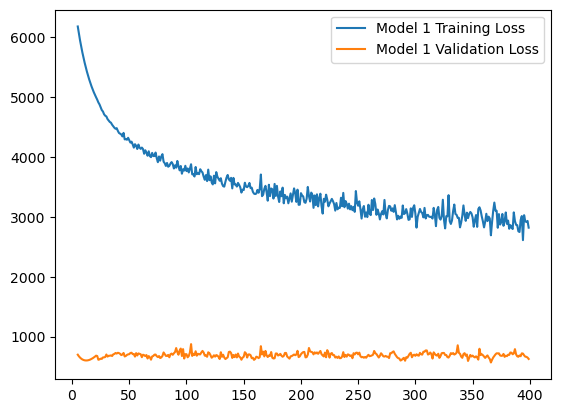

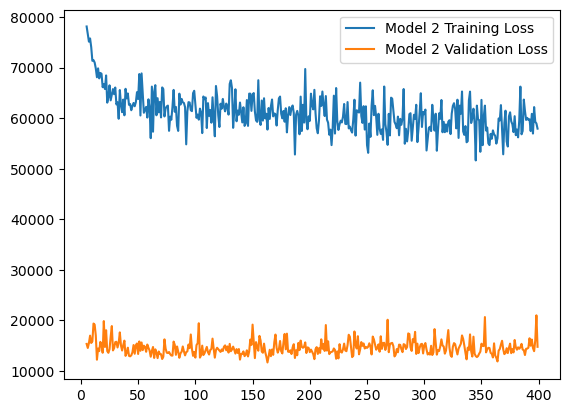

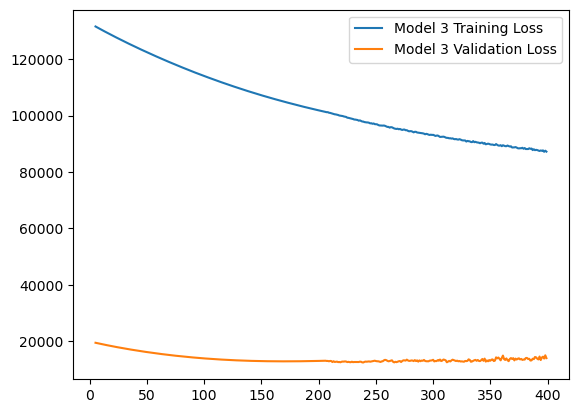

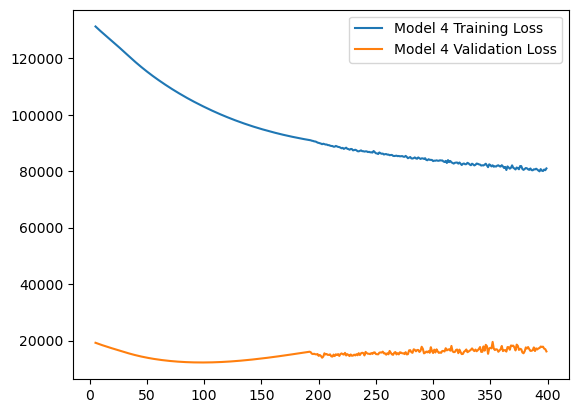

In [36]:

for i in range(len(fit_history_indices)):
    history = fit_histories[i]
    label=fit_history_labels[i]
    fit_index=fit_history_indices[i] # global model index
    print(f'Giving fitting history information for {label}')
    print(type(history))
    print(history)
    history_df = pd.DataFrame(history.history)
    print(history_df.columns)
    # Start the plot at epoch 5
    history_df.loc[5:, ['loss', 'val_loss']].plot()
    plt.legend([f'Model {i+1} Training Loss',f'Model {i+1} Validation Loss'])
    plt.savefig(f'model_{label}_fit_history.png')
    #history_df.loc[5:, ['y_step_10_loss', 'val_y_step_10_loss']].plot()
    #plt.legend(['Training Loss (Step 10)','Validation Loss (Step 10)'])
    #plt.savefig(f'model_{label}_fit_history.png')

# Produce Predictions

In [37]:
y_pred_train_list=[]
y_pred_valid_list=[]

for i in range(len(model_list)):
    model=model_list[i]
    model_label=model_labels[i]
    X_train=X_train_list[i]
    y_train=y_train_list[i]
    X_valid=X_valid_list[i]
    y_valid=y_valid_list[i]
    
    print(f'Producing predictions for model {model_label}')
    if model_label[0:2] == "NN":
        print("I think this is a Neural Net model. Formatting input and output accordingly.")
        #print(type(X_train))
        #print(X_train.shape)
        #print(X_train[:1])
        temp_predict_train = model.predict(X_train)
        print(type(temp_predict_train[0]))
        if model_label != 'NN_1_Dew':
            temp_predict_train=np.concatenate(temp_predict_train,axis=1)
        #print(temp_predict_train)
        #print(f'temp_predict_train is a {type(temp_predict_train)} of size {len(temp_predict_train)}')
        #for item in temp_predict_train:
        #    print(type(item))
        #    print(item.size)
        #print(temp_predict_train)
        #print(f'y_train shape = {y_train.shape}')
        y_pred_train = pd.DataFrame(temp_predict_train,index=y_train.index,columns=y_train.columns)
        #y_pred_train = pd.DataFrame.from_dict(dict(zip(y_train.columns,temp_predict_train)))

        print(f'y_pred_train df has shape {y_pred_train.shape}')
        print(y_pred_train.head())
        #y_pred_train = pd.DataFrame(temp_predict_train,index=y_train.index,columns=y_train.columns,)
        #y_pred_train = pd.DataFrame(model.predict(X_train),index=y_train.index,
        #                      columns=y_train.columns,).clip(0.0)
        
        temp_predict_valid = model.predict(X_valid)
        print(type(temp_predict_valid))
        if model_label != 'NN_1_Dew':
            temp_predict_valid=np.concatenate(temp_predict_valid,axis=1)
        
        y_pred_valid = pd.DataFrame(temp_predict_valid,index=y_valid.index,columns=y_valid.columns)
        
        #y_pred_valid = pd.DataFrame.from_dict(dict(zip(y_valid.columns,temp_predict_valid)))
        #y_pred_valid = pd.DataFrame(temp_predict_valid,index=y_valid.index,columns=y_valid.columns,)
        #y_pred_valid = pd.DataFrame(model.predict(X_valid),index=y_valid.index,
        #                      columns=y_valid.columns,).clip(0.0)
    
    else:
        y_pred_train = pd.DataFrame(model.predict(X_train),index=y_train.index,
                              columns=y_train.columns,).clip(0.0)
        y_pred_valid = pd.DataFrame(model.predict(X_valid),index=y_valid.index,
                              columns=y_valid.columns,).clip(0.0)
    
    y_pred_train_list.append(y_pred_train)
    y_pred_valid_list.append(y_pred_valid)
    
#y_2_pred_train = pd.DataFrame(model_2.predict(X_2_train),index=y_2_train.index,
#                              columns=y_2_train.columns,).clip(0.0)

#y_2_pred_valid = pd.DataFrame(model_2.predict(X_2_valid),index=y_2_valid.index,
#                              columns=y_2_valid.columns,).clip(0.0)


Producing predictions for model RegChain1_Target_Only
Producing predictions for model RegChain1_Dew
Producing predictions for model RegChain1_Dew_Temp
Producing predictions for model RegChain1_Dew_Temp_Hum
Producing predictions for model RegChain1_Dew_Temp_Hum_Precip
Producing predictions for model NN_1_Dew
I think this is a Neural Net model. Formatting input and output accordingly.
14/14 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
y_pred_train df has shape (433, 20)
                    y_step_1   y_step_2   y_step_3   y_step_4   y_step_5  \
weeks_since_start                                                          
29                 24.476353  26.673531  29.116949  31.146252  32.994850   
30                 26.305546  28.493376  30.959669  32.990112  34.874531   
31                 28.752407  30.458128  32.279091  33.616302  34.996284   
32                 29.868401  31.328587  32.812645  33.828640  34.920238   
33                 29.735603  30.777006  31.9

# Run Metrics

In [38]:
import tensorflow_addons as tfa

In [39]:
rmse_train_list=[]
rmse_valid_list=[]
rsquare_list=[]

# metric for NNs
r_square_metric = tfa.metrics.RSquare()

for i in range(len(model_list)):
    model=model_list[i]
    model_label=model_labels[i]
    
    X_valid=X_valid_list[i]
    y_train=y_train_list[i]
    y_valid=y_valid_list[i]
    y_pred_train=y_pred_train_list[i]
    y_pred_valid=y_pred_valid_list[i]

    print(f'y_train has type {type(y_train)}')
    print(f'y_pred_train has type {type(y_pred_train)}')
    
    print(f'y_train has shape {y_train.shape}')
    print(f'y_pred_train has shape {y_pred_train.shape}')

    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
    
    if model_label[0:2] == "NN":
        print(type(model))
        # storing 3, an impossible value, for now
        r_square=3
        #r_square = tfa.metrics.RSquare
        #r_square=model.score(X_valid,y_valid)
    else:
        r_square=model.score(X_valid,y_valid)
    
    rmse_train_list.append(train_rmse)
    rmse_valid_list.append(test_rmse)
    rsquare_list.append(r_square)
    
    print(f'Model {model_label}')
    print(f' RMSE(training,valid)=({train_rmse:.2f},{test_rmse:.2f})')
    print(f'           R^2(valid)=({r_square:.2f})')
#print('Model Two:')
#print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
#print('')

#r_square=model_2.score(X_2_valid,y_2_valid)
#print(f"Model 2 Train R^2: {r_square:.2f}\n")

y_train has type <class 'pandas.core.frame.DataFrame'>
y_pred_train has type <class 'pandas.core.frame.DataFrame'>
y_train has shape (507, 20)
y_pred_train has shape (507, 20)
Model RegChain1_Target_Only
 RMSE(training,valid)=(28.24,40.08)
           R^2(valid)=(-1.97)
y_train has type <class 'pandas.core.frame.DataFrame'>
y_pred_train has type <class 'pandas.core.frame.DataFrame'>
y_train has shape (463, 20)
y_pred_train has shape (463, 20)
Model RegChain1_Dew
 RMSE(training,valid)=(18.41,23.07)
           R^2(valid)=(0.07)
y_train has type <class 'pandas.core.frame.DataFrame'>
y_pred_train has type <class 'pandas.core.frame.DataFrame'>
y_train has shape (463, 20)
y_pred_train has shape (463, 20)
Model RegChain1_Dew_Temp
 RMSE(training,valid)=(18.26,22.42)
           R^2(valid)=(0.13)
y_train has type <class 'pandas.core.frame.DataFrame'>
y_pred_train has type <class 'pandas.core.frame.DataFrame'>
y_train has shape (463, 20)
y_pred_train has shape (463, 20)
Model RegChain1_Dew_Temp_Hu

In [40]:
print(rmse_train_list)
print(rmse_valid_list)
print(rsquare_list)

[28.236725939578537, 18.407631761504774, 18.263577144867405, 18.802122283087098, 16.02733170098461, 50.744107652222894, 53.20545107280096, 66.11265765302511, 62.99877780664332]
[40.07582085394115, 23.069235813501454, 22.421103764771175, 23.395251002792655, 23.89967695921746, 25.005246704270707, 27.12641985164017, 26.480413316465494, 28.070076855034635]
[-1.9715916006250929, 0.07176022707653108, 0.12847098779826407, 0.05123001969617692, 0.011848963962103765, 3, 3, 3, 3]


# Plot Results

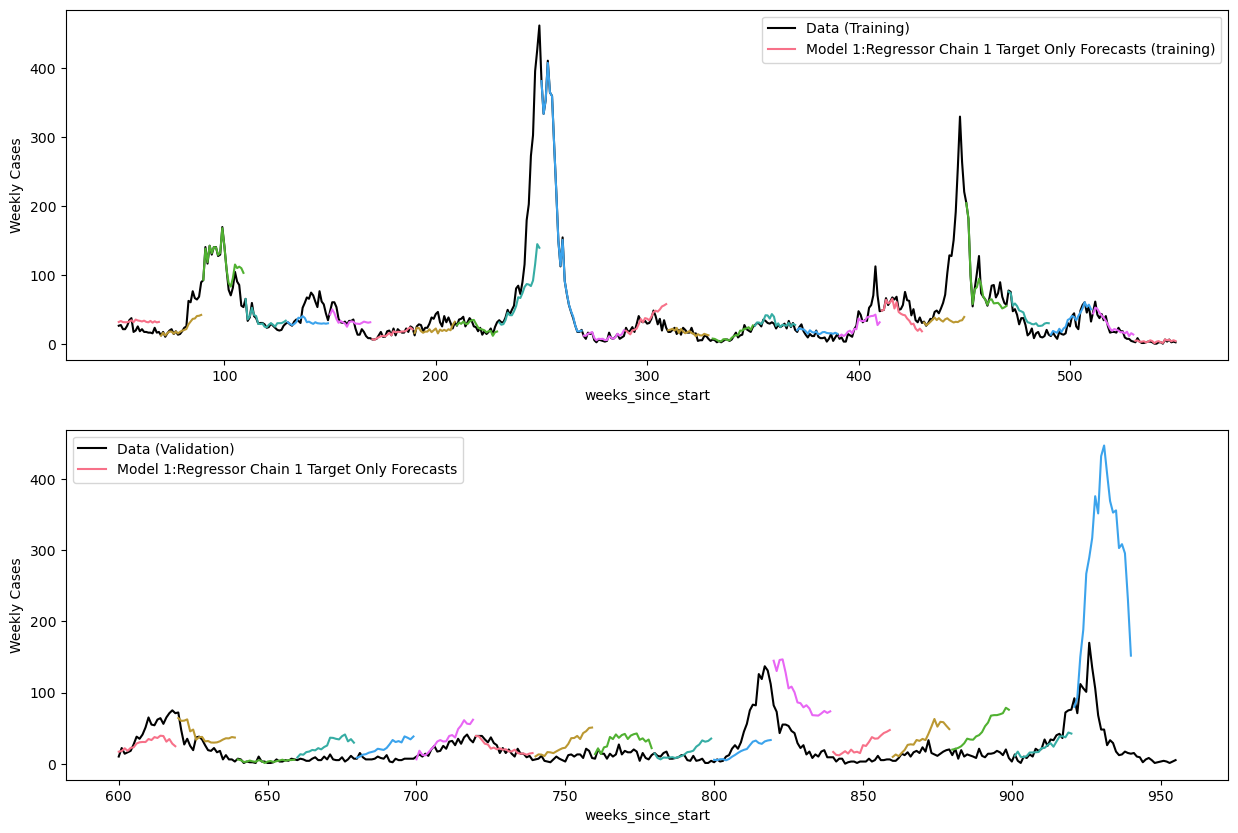

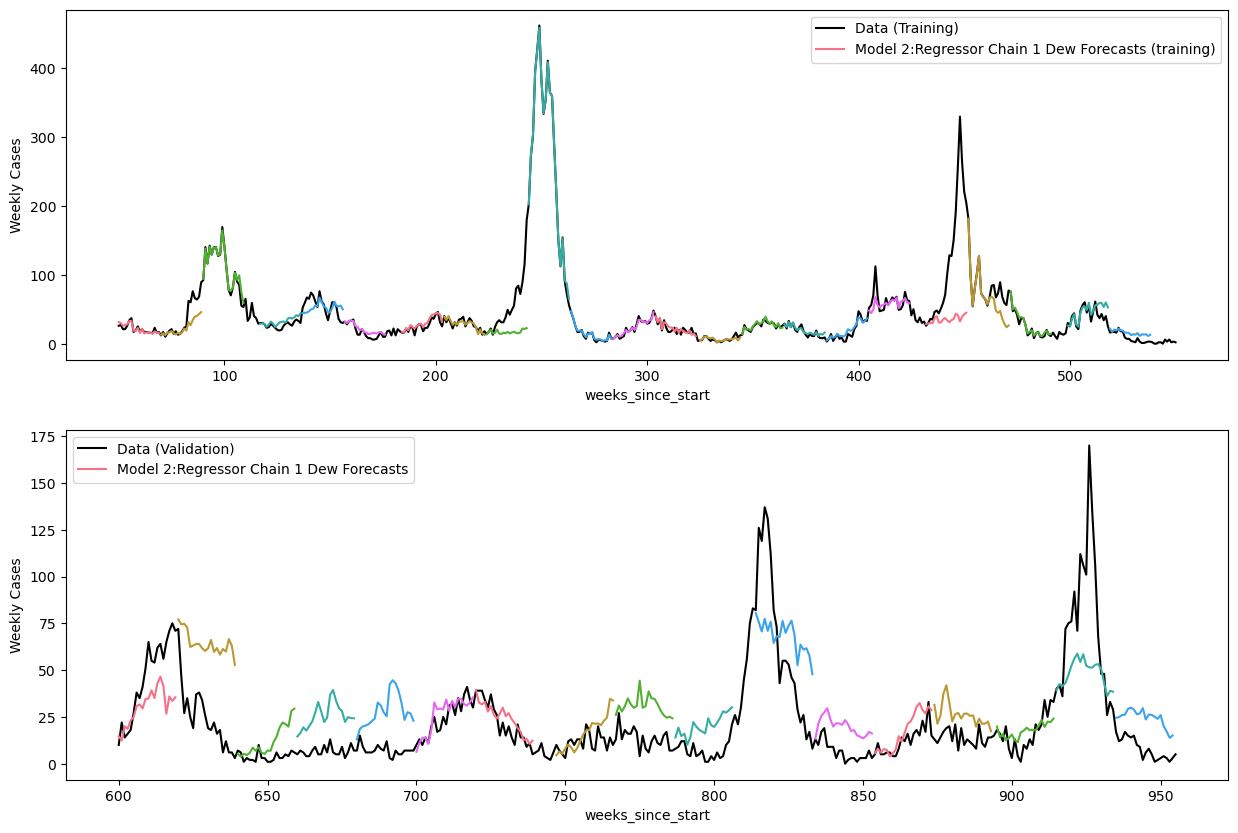

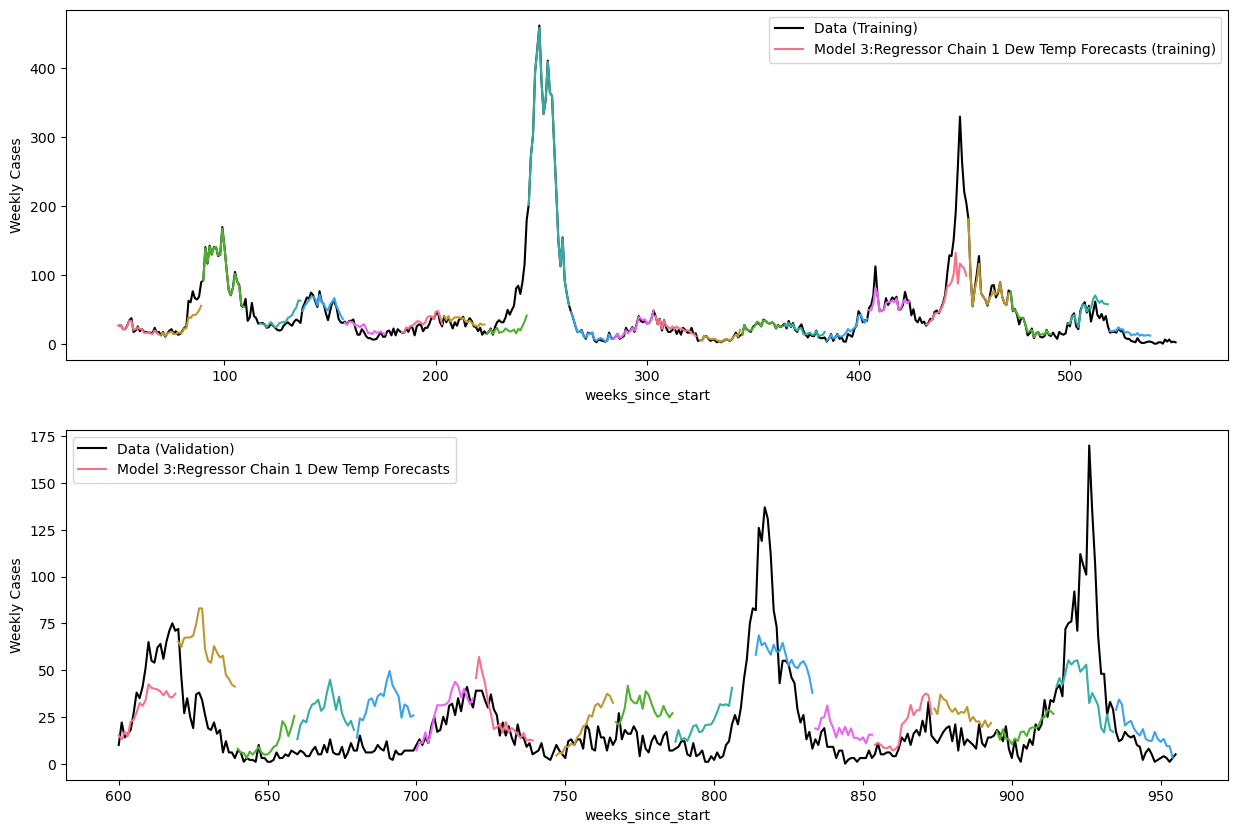

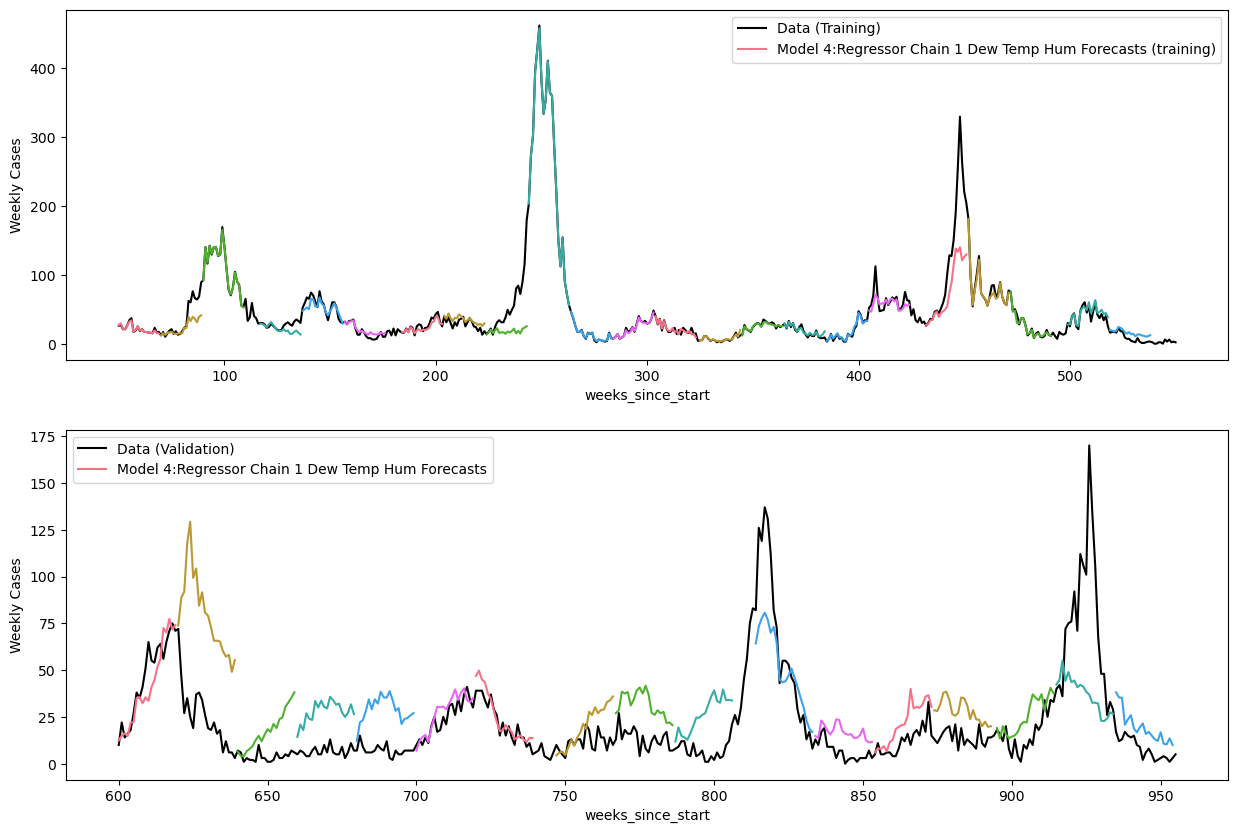

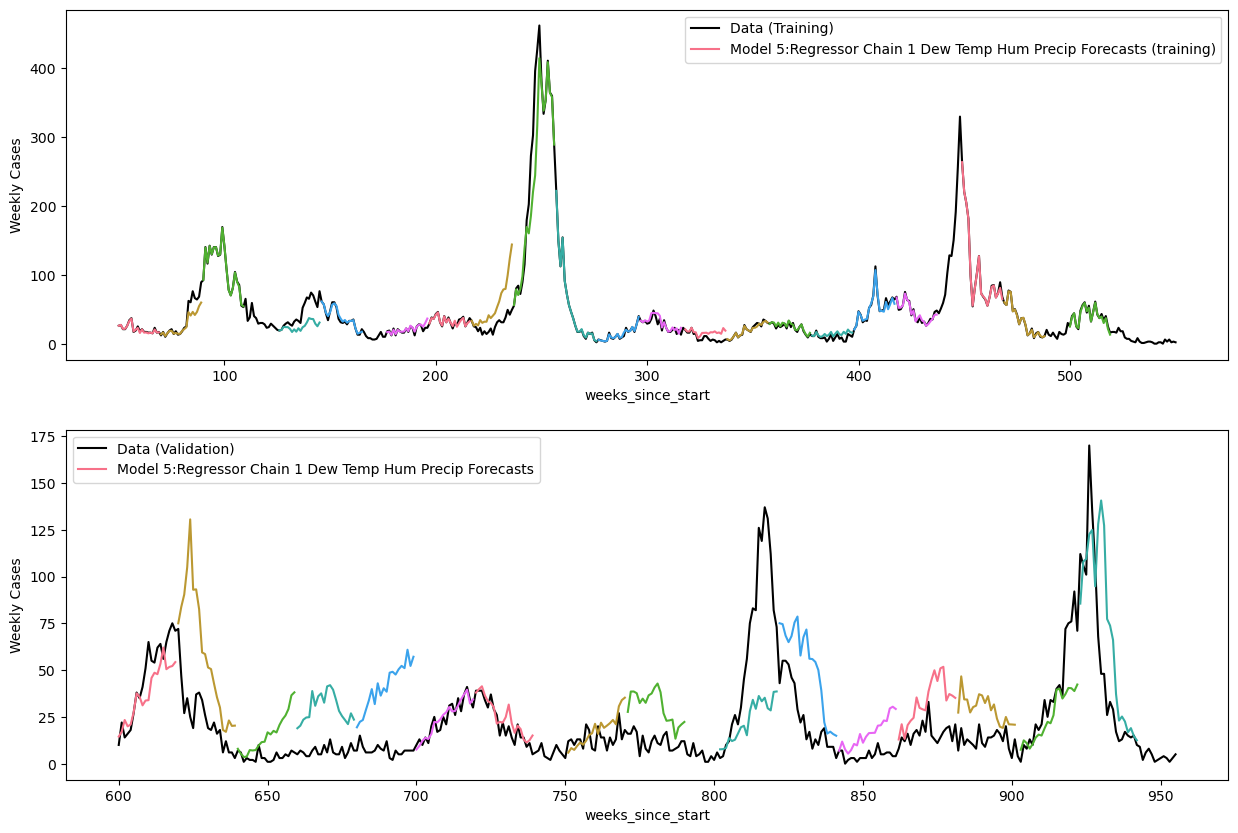

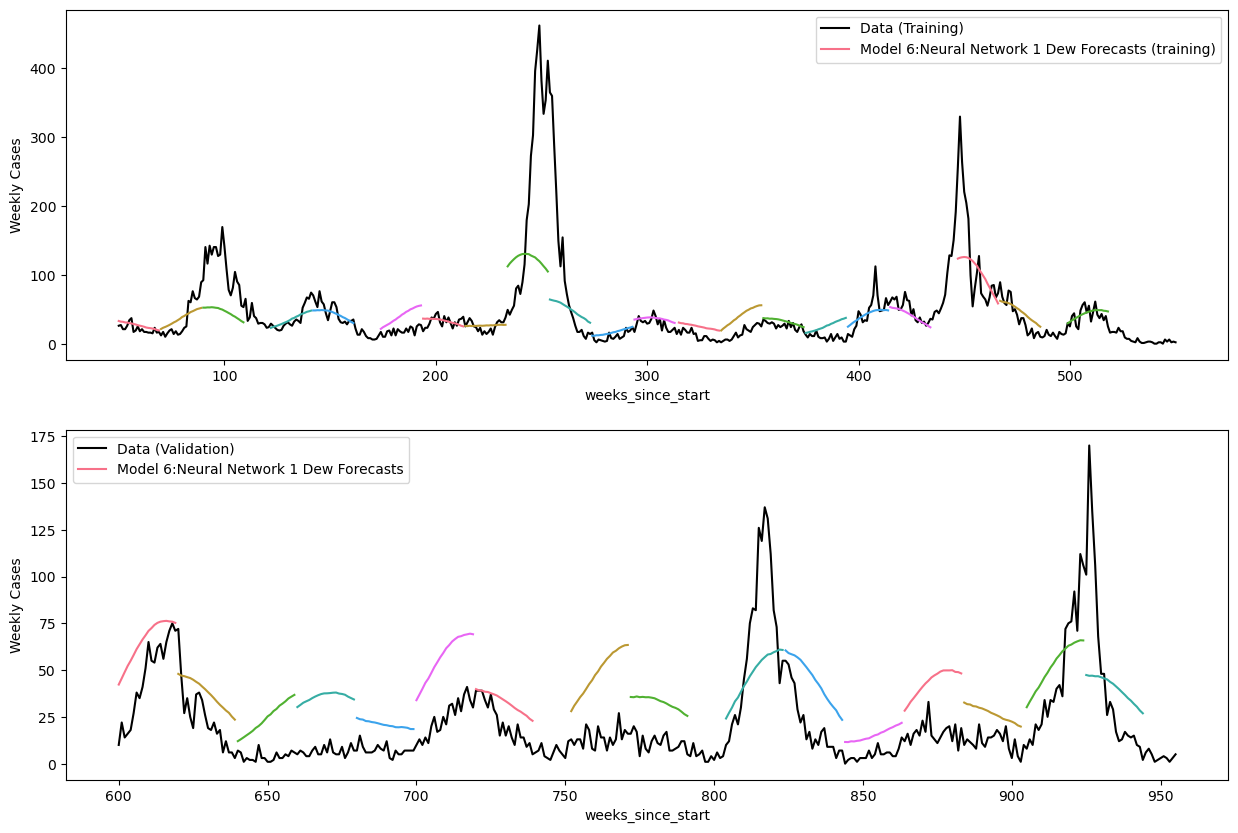

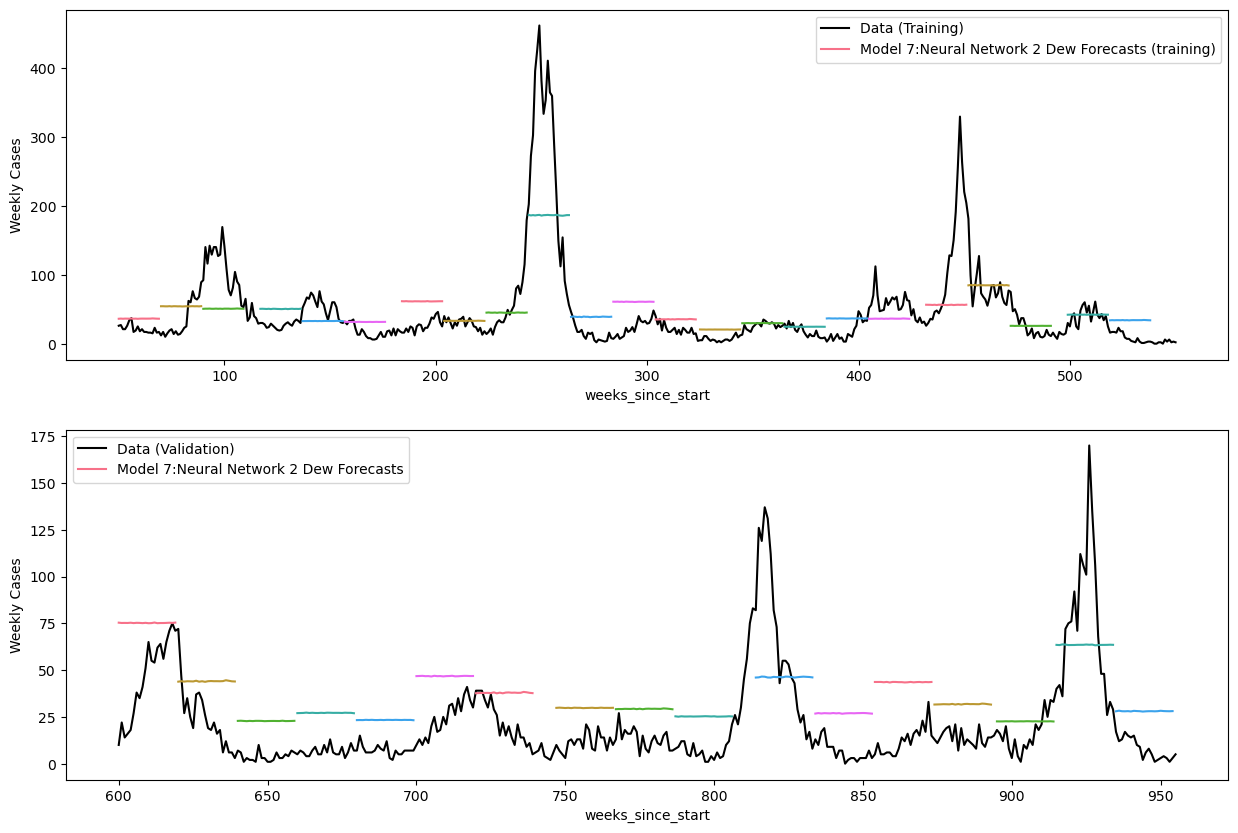

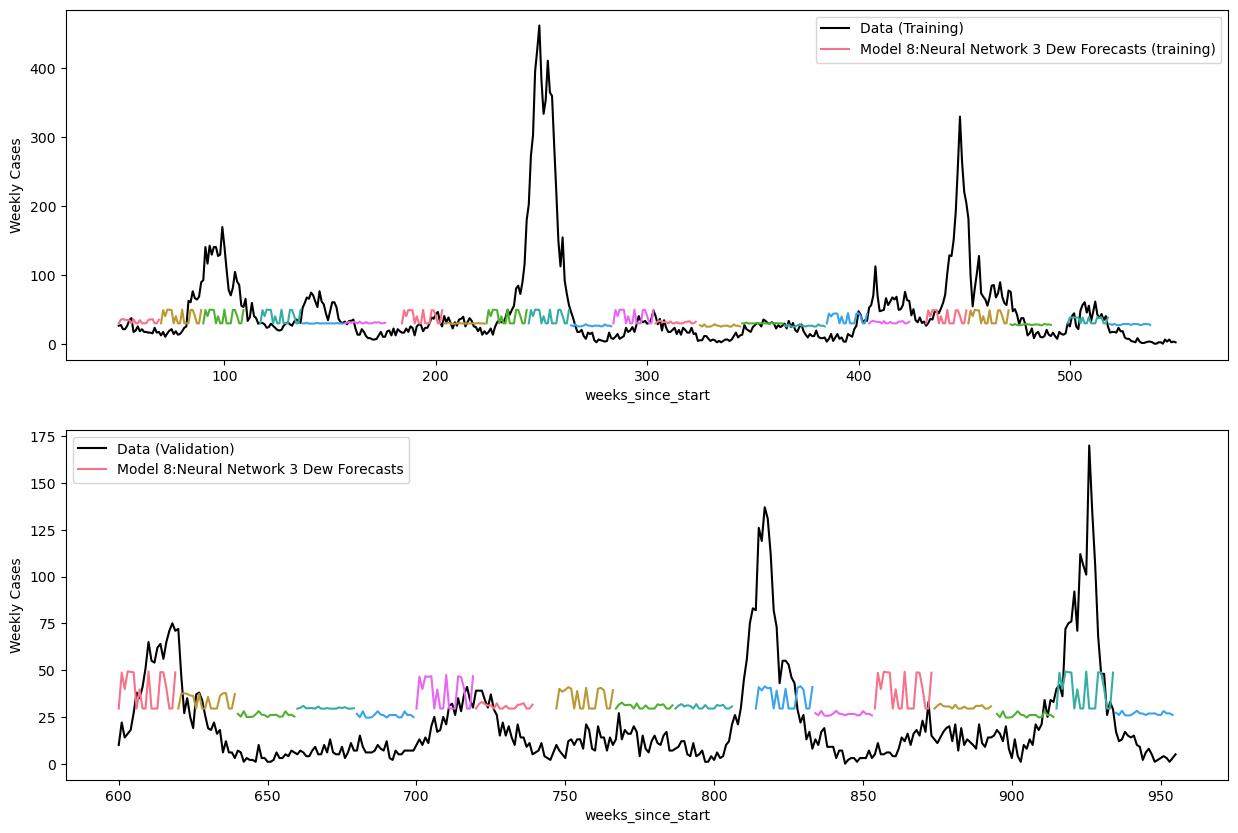

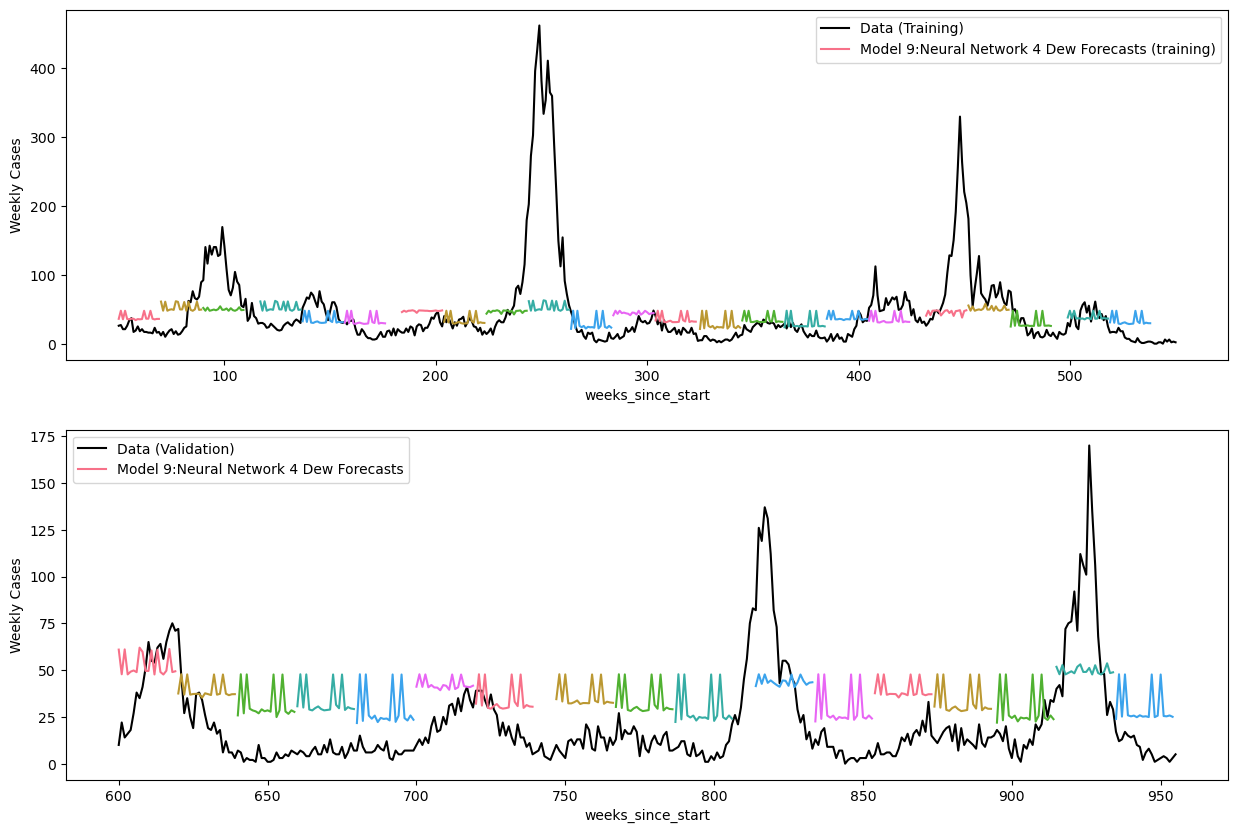

In [41]:

for i in range(len(model_list)):
    y_pred_train = y_pred_train_list[i]
    y_pred_valid = y_pred_valid_list[i]

    model_name  = model_labels[i]
    model_title = model_titles[i]

    EVERY = 20

    START=50
    END=550
    
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 10))
    line1 = y_sj.loc[START:END].plot(ax=ax1,label='Data',color='black')

    x=plot_multistep(y_pred_train.loc[START:END],ax=ax1,every=EVERY)
    ax1.set_ylabel('Weekly Cases')
    ax1.legend(['Data (Training)',f'Model {i+1}:{model_title} Forecasts (training)'])

    EVERY = 20

    START=600
    END=1100

    #fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    line1 = y_sj.loc[START:END].plot(ax=ax2,label='Data',color='black')

    x=plot_multistep(y_pred_valid.loc[START:END],ax=ax2,every=EVERY)

    ax2.set_ylabel('Weekly Cases')
    ax2.legend(['Data (Validation)',f'Model {i+1}:{model_title} Forecasts'])

    plt.savefig(f'model_{i+1}_{model_name}.png')

Clearly, the NNs are having issues. Some ideas for causes/fixes:
* Maybe the loss isn't being applied to all the forecast steps. For NN3, the loss function for step 10 doesn't change, although the same loss function does change for NNs 1 and 2.
* Not deep enough? The system has the nonlinear dependence on the current rate of dengue. The environmental features are probably roughly linear.

Will also try some following ideas from https://www.tensorflow.org/tutorials/structured_data/time_series:
* Long Term Short Term RNNs
* CNNs (read that this can work with time series)
* Residual Wrapper, which uses the output of the network for the change in cases, not the absolute value

